In [13]:
import pandas as pd

# Load the dataset to inspect its contents
file_path = '/DaNang_2000_2024.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure and contents
data.head()


,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_speed,wind_deg,wind_gust,rain_1h,rain_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,946684800,2000-01-01 00:00:00 +0000 UTC,25200,Da Nang,16.054456,108.071722,20.83,10000.0,19.66,21.40,...,1.00,290,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d
1,946688400,2000-01-01 01:00:00 +0000 UTC,25200,Da Nang,16.054456,108.071722,21.12,6000.0,19.05,21.59,...,0.67,260,NaN,NaN,NaN,20,801,Clouds,few clouds,02d
2,946692000,2000-01-01 02:00:00 +0000 UTC,25200,Da Nang,16.054456,108.071722,21.72,7000.0,19.65,22.25,...,3.00,330,NaN,0.11,NaN,75,500,Rain,light rain,10d
3,946695600,2000-01-01 03:00:00 +0000 UTC,25200,Da Nang,16.054456,108.071722,22.50,10000.0,19.66,23.00,...,1.00,340,NaN,0.10,NaN,40,500,Rain,light rain,10d
4,946699200,2000-01-01 04:00:00 +0000 UTC,25200,Da Nang,16.054456,108.071722,22.98,8000.0,17.88,23.24,...,3.00,10,NaN,0.15,NaN,20,500,Rain,light rain,10d


In [14]:
# Drop irrelevant columns and those we won't use
# Exclude rain_3h as requested, and drop columns like 'timezone', 'city_name', 'lat', 'lon' since they're not necessary for modeling
data = data.drop(columns=['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'rain_3h', 'weather_icon'])

# Check for missing values to decide on handling strategy
missing_values = data.isnull().sum()

# Display the missing values count for each column
missing_values


,0
temp,0
visibility,11976
dew_point,0
feels_like,0
temp_min,0
temp_max,0
pressure,0
sea_level,217467
grnd_level,217467
humidity,0


In [15]:
# Drop columns with excessive missing values: 'sea_level', 'grnd_level', and 'wind_gust'
data = data.drop(columns=['sea_level', 'grnd_level', 'wind_gust'])

# Fill missing values in 'rain_1h' with 0, assuming no recorded rain means no rain
data['rain_1h'].fillna(0, inplace=True)

# Use forward-fill for 'visibility' to maintain continuity in visibility records
data['visibility'].fillna(method='ffill', inplace=True)

# Verify that there are no remaining missing values
remaining_missing = data.isnull().sum().sum()
remaining_missing


<ipython-input-15-9f6bab6134e8>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['visibility'].fillna(method='ffill', inplace=True)


0

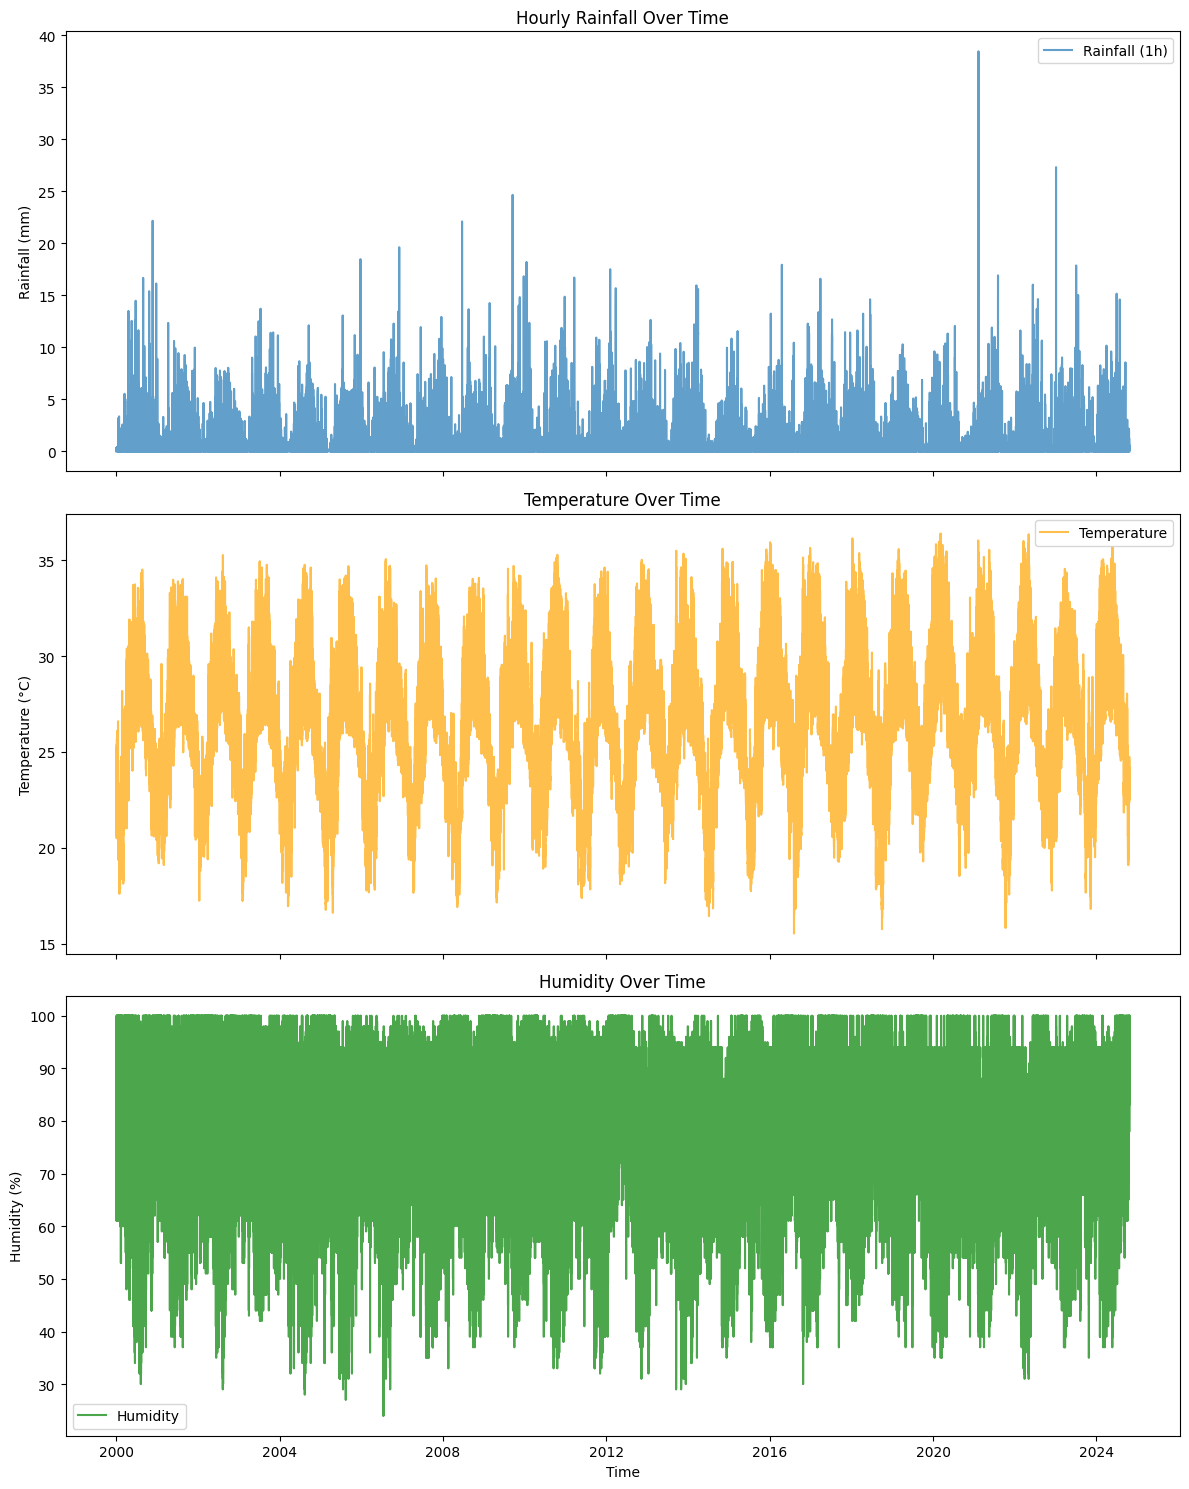

In [16]:
import matplotlib.pyplot as plt

# Convert date-related information to datetime format for easier plotting by setting a time index
data['timestamp'] = pd.to_datetime(data.index, unit='h', origin='2000-01-01')

# Set timestamp as index for easier plotting and analysis
data.set_index('timestamp', inplace=True)

# Plot key variables over time to observe trends: rain, temperature, and humidity
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Plot rainfall over time
axes[0].plot(data.index, data['rain_1h'], label='Rainfall (1h)', alpha=0.7)
axes[0].set_title('Hourly Rainfall Over Time')
axes[0].set_ylabel('Rainfall (mm)')
axes[0].legend()

# Plot temperature over time
axes[1].plot(data.index, data['temp'], label='Temperature', color='orange', alpha=0.7)
axes[1].set_title('Temperature Over Time')
axes[1].set_ylabel('Temperature (°C)')
axes[1].legend()

# Plot humidity over time
axes[2].plot(data.index, data['humidity'], label='Humidity', color='green', alpha=0.7)
axes[2].set_title('Humidity Over Time')
axes[2].set_ylabel('Humidity (%)')
axes[2].legend()

# Show plots
plt.xlabel('Time')
plt.tight_layout()
plt.show()


In [17]:
# Define a threshold for flood-prone conditions based on domain knowledge
# Assumption: Flood-prone if rainfall > 50 mm in an hour OR humidity > 85% and significant rain

# Create a 'flood_prone' column as the target variable
data['flood_prone'] = ((data['rain_1h'] > 50) | ((data['humidity'] > 85) & (data['rain_1h'] > 10))).astype(int)

# Generate lag features to capture cumulative effects of rainfall
data['rain_1h_lag_1'] = data['rain_1h'].shift(1).fillna(0)
data['rain_1h_lag_3'] = data['rain_1h'].rolling(window=3).sum().fillna(0)
data['humidity_lag_3'] = data['humidity'].rolling(window=3).mean().fillna(0)

# Select features and target for the model
features = data[['rain_1h', 'rain_1h_lag_1', 'rain_1h_lag_3', 'humidity', 'humidity_lag_3', 'temp']]
target = data['flood_prone']

# Display the prepared data for modeling
features.head(), target.head()


(                     rain_1h  rain_1h_lag_1  rain_1h_lag_3  humidity  \
 timestamp                                                              
 2000-01-01 00:00:00     0.00           0.00           0.00        93   
 2000-01-01 01:00:00     0.00           0.00           0.00        88   
 2000-01-01 02:00:00     0.11           0.00           0.11        88   
 2000-01-01 03:00:00     0.10           0.11           0.21        84   
 2000-01-01 04:00:00     0.15           0.10           0.36        73   
 
                      humidity_lag_3   temp  
 timestamp                                   
 2000-01-01 00:00:00        0.000000  20.83  
 2000-01-01 01:00:00        0.000000  21.12  
 2000-01-01 02:00:00       89.666667  21.72  
 2000-01-01 03:00:00       86.666667  22.50  
 2000-01-01 04:00:00       81.666667  22.98  ,
 timestamp
 2000-01-01 00:00:00    0
 2000-01-01 01:00:00    0
 2000-01-01 02:00:00    0
 2000-01-01 03:00:00    0
 2000-01-01 04:00:00    0
 Name: flood_prone, dty

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Generate and display classification report
report = classification_report(y_test, y_pred, target_names=['Non-Flood', 'Flood-Prone'])
report


'              precision    recall  f1-score   support\n\n   Non-Flood       1.00      1.00      1.00     43436\n Flood-Prone       1.00      1.00      1.00        58\n\n    accuracy                           1.00     43494\n   macro avg       1.00      1.00      1.00     43494\nweighted avg       1.00      1.00      1.00     43494\n'

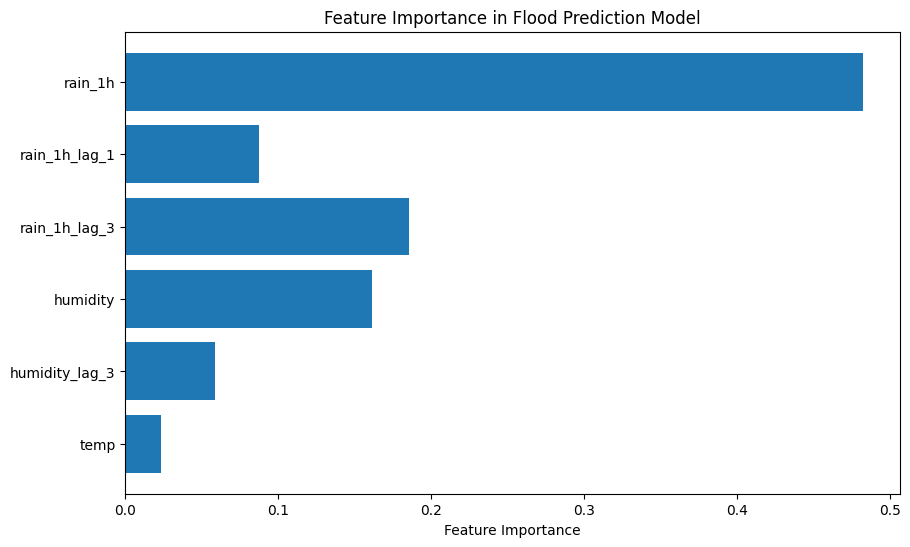

In [19]:
# Retrieve and plot feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
feature_names = features.columns

# Create a bar plot to show feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, align='center')
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Flood Prediction Model")
plt.gca().invert_yaxis()
plt.show()


In [20]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds on the Random Forest model
cv_scores = cross_val_score(rf_model, features, target, cv=5, scoring='f1')

# Display cross-validation F1 scores and mean score
cv_scores, cv_scores.mean()


(array([1.        , 0.99029126, 0.99029126, 1.        , 1.        ]),
 0.996116504854369)

In [22]:
# Filter data for the year 2024
data_2024 = data.loc['2024']

# Predict flood-prone conditions for 2024
data_2024['flood_prone_pred'] = rf_model.predict(data_2024[features.columns])

# Extract the month from the timestamp
data_2024['month'] = data_2024.index.month

# Group by month and sum the flood-prone predictions
monthly_flood_predictions = data_2024.groupby('month')['flood_prone_pred'].sum()

# Display monthly flood-prone hours for 2024
print(monthly_flood_predictions)



month
1     0
2     0
3     0
4     0
5     0
6     2
7     5
8     0
9     0
10    0
Name: flood_prone_pred, dtype: int64


<ipython-input-22-bfbcd545aa02>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2024['flood_prone_pred'] = rf_model.predict(data_2024[features.columns])
<ipython-input-22-bfbcd545aa02>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2024['month'] = data_2024.index.month


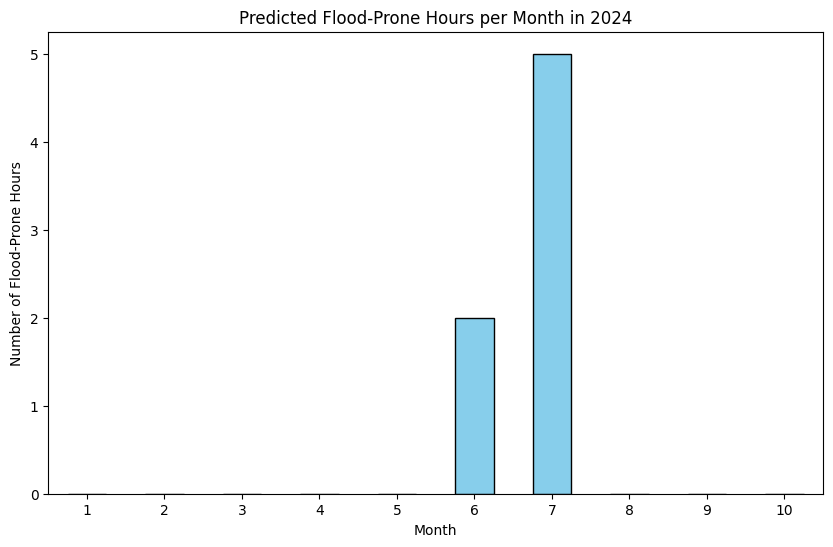

In [23]:
# Plotting the monthly flood-prone hours in 2024 for easy visualization
import matplotlib.pyplot as plt

# Plotting the monthly flood-prone hours based on predictions
plt.figure(figsize=(10, 6))
monthly_flood_predictions.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Predicted Flood-Prone Hours per Month in 2024')
plt.xlabel('Month')
plt.ylabel('Number of Flood-Prone Hours')
plt.xticks(rotation=0)
plt.show()
